In [10]:
# from nltk.corpus import stopwords
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

string = 'I am a cat. As yet I have no name.'
# 各単語のリストを作ってくれる
words = nltk.word_tokenize(string)

print(words)

# 各単語にタグを付けている
tags = nltk.pos_tag(words)

print(tags)

[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Mamo\AppData\Roaming\nltk_data...
['I', 'am', 'a', 'cat', '.', 'As', 'yet', 'I', 'have', 'no', 'name', '.']
[('I', 'PRP'), ('am', 'VBP'), ('a', 'DT'), ('cat', 'NN'), ('.', '.'), ('As', 'IN'), ('yet', 'RB'), ('I', 'PRP'), ('have', 'VBP'), ('no', 'DT'), ('name', 'NN'), ('.', '.')]
[nltk_data]   Unzipping help\tagsets.zip.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam


Using TensorFlow backend.


In [23]:
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mamo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [11]:
# 各タグの説明
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [5]:
import pandas as pd

tweet = pd.read_csv('nlp-getting-started/train.csv')
test = pd.read_csv('nlp-getting-started/train.csv')

tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 7613 rows and 5 columns in train


Text(0, 0.5, 'samples')

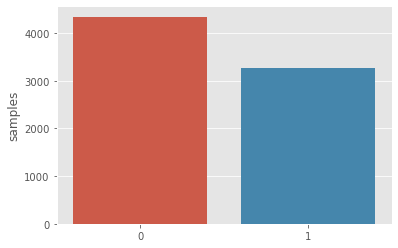

In [7]:
# まずは1と0が何個ずつあるか見る

x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

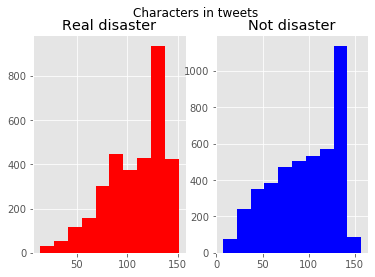

In [8]:
# Real disasterに関するtweetとそうではないtweetの文字数はどんなもんか見てみる

fig, axes = plt.subplots(1, 2)
tweet_len = tweet[tweet['target']==1]['text'].str.len()
axes[0].hist(tweet_len, color='r')
axes[0].set_title('Real disaster')
tweet_len = tweet[tweet['target'] == 0]['text'].str.len()
axes[1].hist(tweet_len, color='b')
axes[1].set_title('Not disaster')
fig.suptitle('Characters in tweets')
plt.show()

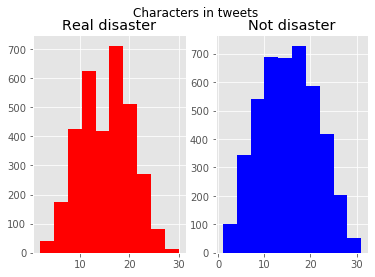

In [9]:
# 単語数は?

fig, axes = plt.subplots(1, 2)
tweet_len = tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
axes[0].hist(tweet_len, color='r')
axes[0].set_title('Real disaster')
tweet_len = tweet[tweet['target'] == 0]['text'].str.split().map(lambda x: len(x))
axes[1].hist(tweet_len, color='b')
axes[1].set_title('Not disaster')
fig.suptitle('Characters in tweets')
plt.show()

Text(0.5, 1.0, 'disaster')

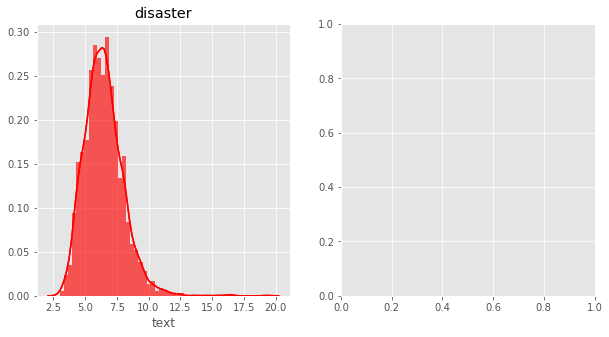

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')

In [12]:
tweet[tweet['target']==1]['text'].str.split()

0       [Our, Deeds, are, the, Reason, of, this, #eart...
1          [Forest, fire, near, La, Ronge, Sask., Canada]
2       [All, residents, asked, to, 'shelter, in, plac...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, this, photo, from, Ruby, #Al...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @TheTawniest, The, out, of, con...
7610    [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...
7611    [Police, investigating, after, an, e-bike, col...
7612    [The, Latest:, More, Homes, Razed, by, Norther...
Name: text, Length: 3271, dtype: object